# Find Fixed Points

The goal of this tutorial is to learn about fixed point finding by running the algorithm on a simple data generator, a Gated Recurrent Unit (GRU) that is trained to make a binary decision, namely whether the integral of the white noise input is in total positive or negative, outputing either a +1 or a -1.

In this tutorial we do a few things:

- Train the decision making GRU
- Find the fixed points of the GRU

In [1]:
import brainpy as bp
import brainpy.math.jax as bm

bp.math.use_backend('jax')
bp.__version__

'1.1.0'

In [2]:
import time
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

## Parameters

In [3]:
# Integration parameters

T = 1.0  # Arbitrary amount time, roughly physiological.
dt = 0.04
num_step = int(T / dt)  # Divide T into this many bins
bval = 0.01  # bias value limit
sval = 0.025  # standard deviation (before dividing by sqrt(dt))

In [4]:
# Optimization hyperparameters

l2reg = 0.00002  # amount of L2 regularization on the weights
num_train = int(2e4)  # Total number of batches to train on.
num_batch = 150  # How many examples in each batch
# Gradient clipping is HUGELY important for training RNNs
# max gradient norm before clipping, clip to this value.
max_grad_norm = 10.0

## Helpers

In [5]:
def plot_examples(num_time, inputs, hiddens, outputs, targets, num_example=1,
                  num_plot=10, start_id=0):
  """Plot some input/hidden/output triplets.
  
  Parameters
  ----------
  inputs: ndarray of (num_time, num_batch)
  hiddens: ndarray of (num_time, num_batch, num_hidden)
  outputs: ndarray of (num_time, num_batch, num_output)
  targets: ndarray of (num_time, num_batch, num_output)
  """
  plt.figure(figsize=(num_example * 5, 14))
  selected_ids = list(range(start_id, start_id + num_example))

  for i, bidx in enumerate(selected_ids):
    plt.subplot(3, num_example, i + 1)
    plt.plot(inputs[:, bidx], 'k')
    plt.xlim([0, num_time])
    plt.title('Example %d' % bidx)
    if bidx == 0: plt.ylabel('Input Units')

  closeness = 0.25
  for i, bidx in enumerate(selected_ids):
    plt.subplot(3, num_example, num_example + i + 1)
    plt.plot(hiddens[:, bidx, 0:num_plot] + closeness * np.arange(num_plot), 'b')
    plt.xlim([0, num_time])
    if bidx == 0: plt.ylabel('Hidden Units')

  for i, bidx in enumerate(selected_ids):
    plt.subplot(3, num_example, 2 * num_example + i + 1)
    plt.plot(outputs[:, bidx, :], 'r', label='predict')
    plt.plot(targets[:, bidx, :], 'k', label='target')
    plt.xlim([0, num_time])
    plt.xlabel('Time steps')
    plt.legend()
    if bidx == 0: plt.ylabel('Output Units')

  plt.show()

In [6]:
def plot_params(rnn, show_top_eig=0):
  """Plot the parameters. """
  assert isinstance(rnn, GRU)

  plt.figure(figsize=(16, 8))
  plt.subplot(231)
  plt.stem(rnn.w_ro.numpy()[:, 0])
  plt.title('W_ro - output weights')

  plt.subplot(232)
  plt.stem(rnn.h0)
  plt.title('h0 - initial hidden state')

  a = bm.concatenate([rnn.w_ir, rnn.w_iz], axis=0)
  b = bm.concatenate([rnn.w_hr, rnn.w_hz], axis=0)
  c = bm.concatenate([a, b], axis=0).numpy()

  plt.subplot(233)
  plt.imshow(c, interpolation=None)
  plt.colorbar()
  plt.title('[W_ir, W_iz, W_hr, W_hz]')

  plt.subplot(234)
  a = bm.concatenate([rnn.w_ia, rnn.w_ha], axis=0).numpy()
  plt.imshow(a, interpolation=None)
  plt.colorbar()
  plt.title('[W_ia, W_ha]')

  plt.subplot(235)
  plt.stem(bm.concatenate([rnn.bz, rnn.br]).numpy())
  plt.title('[bz, br] - recurrent biases')

  plt.subplot(236)
  dFdh = bm.jacobian(rnn.cell)(rnn.h0.value, bm.zeros(rnn.num_input))
  evals, _ = np.linalg.eig(dFdh.numpy())
  x = np.linspace(-1, 1, 1000)
  plt.plot(x, np.sqrt(1 - x ** 2), 'k')
  plt.plot(x, -np.sqrt(1 - x ** 2), 'k')
  plt.plot(np.real(evals), np.imag(evals), '.')

  if show_top_eig > 0:
    print(np.sort(np.real(evals))[-show_top_eig:])  

  plt.axis('equal')
  plt.xlabel('Real($\lambda$)')
  plt.ylabel('Imaginary($\lambda$)')
  plt.title('Eigenvalues of $dF/dh(h_0)$')

  plt.show()

In [7]:
def plot_data(num_time, inputs, targets=None, outputs=None, errors=None, num_plot=10):
  """Plot some white noise / integrated white noise examples.

  Parameters
  ----------
  num_time : int
  num_plot : int
  inputs: ndarray
    with the shape of (num_batch, num_time, num_input)
  targets: ndarray
    with the shape of (num_batch, num_time, num_output)
  outputs: ndarray
    with the shape of (num_batch, num_time, num_output)
  errors: ndarray
    with the shape of (num_batch, num_time, num_output)
  """
  num = 1
  if errors is not None: num += 1
  if (targets is not None) or (outputs is not None): num += 1
  plt.figure(figsize=(14, 4 * num))

  # inputs
  plt.subplot(num, 1, 1)
  plt.plot(inputs[:, 0:num_plot, 0])
  plt.xlim([0, num_time])
  plt.ylabel('Noise')

  legends = []
  if outputs is not None:
    plt.subplot(num, 1, 2)
    plt.plot(outputs[:, 0:num_plot, 0])
    plt.xlim([0, num_time])
    legends.append(mlines.Line2D([], [], color='k', linestyle='-', label='predict'))
  if targets is not None:
    plt.subplot(num, 1, 2)
    plt.plot(targets[:, 0:num_plot, 0], '--')
    plt.xlim([0, num_time])
    plt.ylabel("Integration")
    legends.append(mlines.Line2D([], [], color='k', linestyle='--', label='target'))
  if len(legends): plt.legend(handles=legends)

  if errors is not None:
    plt.subplot(num, 1, 3)
    plt.plot(errors[:, 0:num_plot, 0], '--')
    plt.xlim([0, num_time])
    plt.ylabel("|Errors|")

  plt.xlabel('Time steps')
  plt.show()

In [8]:
@partial(bm.jit, dyn_vars={'a': bm.random.DEFAULT}, static_argnames=('num_batch', 'num_step', 'dt'))
def build_inputs_and_targets(mean, scale, num_batch, num_step, dt):
  """Build white noise input and integration targets."""

  # Create the white noise input.
  sample = bm.random.normal(size=(num_batch,))
  bias = mean * 2.0 * (sample - 0.5)
  samples = bm.random.normal(size=(num_step, num_batch))
  noise_t = scale / dt ** 0.5 * samples
  white_noise_t = bias + noise_t
  inputs_txbx1 = bm.expand_dims(white_noise_t, axis=2)

  # * dt, intentionally left off to get output scaling in O(1).
  integration_txbx1 = bm.expand_dims(bm.cumsum(white_noise_t, axis=0), axis=2)
  targets_txbx1 = bm.zeros_like(integration_txbx1)
  targets_txbx1[-1] = 2.0 * ((integration_txbx1[-1] > 0.0) - 0.5)
  # targets_mask = bm.ones((num_batch, 1)) * (num_step - 1)
  return inputs_txbx1, targets_txbx1

In [9]:
# # Plot the example inputs and targets for the RNN.
# _ints, _outs = build_inputs_and_targets(bval, sval, num_batch=num_batch, num_step=num_step, dt=dt)

# plot_data(num_step, inputs=_ints, targets=_outs)

## Model

In [10]:
class GRU(bp.DynamicalSystem):
  def __init__(self, num_hidden, num_input, num_output, num_batch,
               g=1.0, l2_reg=0., forget_bias=0.5, **kwargs):
    super(GRU, self).__init__(**kwargs)

    # parameters
    self.l2_reg = l2_reg
    self.num_input = num_input
    self.num_batch = num_batch
    self.num_hidden = num_hidden
    self.num_output = num_output
    self.rng = bm.random.RandomState()
    self.forget_bias = forget_bias

    # recurrent weights
    self.w_iz = bm.TrainVar(self.rng.normal(scale=1 / num_input ** 0.5, size=(num_input, num_hidden)))
    self.w_ir = bm.TrainVar(self.rng.normal(scale=1 / num_input ** 0.5, size=(num_input, num_hidden)))
    self.w_ia = bm.TrainVar(self.rng.normal(scale=1 / num_input ** 0.5, size=(num_input, num_hidden)))
    self.w_hz = bm.TrainVar(self.rng.normal(scale=g / num_hidden ** 0.5, size=(num_hidden, num_hidden)))
    self.w_hr = bm.TrainVar(self.rng.normal(scale=g / num_hidden ** 0.5, size=(num_hidden, num_hidden)))
    self.w_ha = bm.TrainVar(self.rng.normal(scale=g / num_hidden ** 0.5, size=(num_hidden, num_hidden)))
    self.bz = bm.TrainVar(bm.zeros((num_hidden,)))
    self.br = bm.TrainVar(bm.zeros((num_hidden,)))
    self.ba = bm.TrainVar(bm.zeros((num_hidden,)))
    self.h0 = bm.TrainVar(self.rng.normal(scale=0.1, size=(num_hidden,)))

    # output weights
    self.w_ro = bm.TrainVar(self.rng.normal(scale=1 / num_hidden ** 0.5, size=(num_hidden, num_output)))
    self.b_ro = bm.TrainVar(bm.zeros((num_output,)))

    # variables
    self.h = bm.Variable(self.rng.normal(scale=0.1, size=(num_batch, self.num_hidden)))
    self.o = self.h @ self.w_ro + self.b_ro

    # loss
    self.total_loss = bm.Variable(bm.zeros(1))
    self.l2_loss = bm.Variable(bm.zeros(1))
    self.mse_loss = bm.Variable(bm.zeros(1))

  def cell(self, h, x):
    r = bm.sigmoid(x @ self.w_ir + h @ self.w_hr + self.br)
    z = bm.sigmoid(x @ self.w_iz + h @ self.w_hz + self.bz)
    a = bm.tanh(x @ self.w_ia + (r * h) @ self.w_ha + self.ba)
    return (1. - z) * h + z * a

  def readout(self, h):
    return h @ self.w_ro + self.b_ro

  def make_update(self, h: bm.JaxArray, o: bm.JaxArray):
    def update(x):
      h.value = self.cell(h, x)
      o.value = self.readout(h)

    return update

  def predict(self, xs):
    self.h[:] = self.h0
    f = bm.make_loop(self.make_update(self.h, self.o),
                     dyn_vars=self.vars().unique(),
                     out_vars=[self.h, self.o])
    return f(xs)

  def loss(self, xs, ys):
    hs, os = self.predict(xs)
    l2 = self.l2_reg * bm.losses.l2_norm(self.train_vars().dict()) ** 2
    mse = bm.losses.mean_squared_error(os[-1], ys[-1])
    total = l2 + mse
    self.total_loss[0] = total
    self.l2_loss[0] = l2
    self.mse_loss[0] = mse
    return total

In [11]:
net = GRU(num_input=1, num_hidden=100, num_output=1, num_batch=num_batch, l2_reg=l2reg)

# plot_params(net)

In [12]:
lr = bm.optimizers.ExponentialDecay(lr=0.04, decay_steps=1, decay_rate=0.9999)
optimizer = bm.optimizers.Adam(lr=lr, train_vars=net.train_vars(), eps=1e-1)


@bm.jit
@bm.function(nodes=(net, optimizer))
def train(inputs, targets):
  grad_f = bm.grad(net.loss, dyn_vars=net.vars(), grad_vars=net.train_vars(), return_value=True)
  grads, loss = grad_f(inputs, targets)
  clipped_grads = bm.clip_by_norm(grads, max_grad_norm)
  optimizer.update(clipped_grads)
  return loss

## Training

In [13]:
t0 = time.time()
train_losses = {'total': [], 'l2': [], 'mse': []}
for i in range(num_train):
  _ins, _outs = build_inputs_and_targets(bval, sval, num_batch=num_batch, num_step=num_step, dt=dt)
  loss = train(inputs=_ins, targets=_outs)
  if (i + 1) % 400 == 0:
    print(f"Run batch {i + 1} in {time.time() - t0:0.3f} s, learning rate: {lr():.5f}, training loss {loss:0.4f}")
    train_losses['total'].append(net.total_loss[0])
    train_losses['l2'].append(net.l2_loss[0])
    train_losses['mse'].append(net.mse_loss[0])

Run batch 400 in 12.253 s, learning rate: 0.03843, training loss 0.1153
Run batch 800 in 20.798 s, learning rate: 0.03692, training loss 0.0941
Run batch 1200 in 30.771 s, learning rate: 0.03548, training loss 0.0726
Run batch 1600 in 40.627 s, learning rate: 0.03408, training loss 0.1137
Run batch 2000 in 48.711 s, learning rate: 0.03275, training loss 0.0434
Run batch 2400 in 57.560 s, learning rate: 0.03146, training loss 0.0826
Run batch 2800 in 66.460 s, learning rate: 0.03023, training loss 0.1030
Run batch 3200 in 74.533 s, learning rate: 0.02904, training loss 0.0574
Run batch 3600 in 83.054 s, learning rate: 0.02790, training loss 0.0560
Run batch 4000 in 92.696 s, learning rate: 0.02681, training loss 0.0701
Run batch 4400 in 100.709 s, learning rate: 0.02576, training loss 0.1124
Run batch 4800 in 108.730 s, learning rate: 0.02475, training loss 0.0485
Run batch 5200 in 117.375 s, learning rate: 0.02378, training loss 0.1547
Run batch 5600 in 125.817 s, learning rate: 0.0228

In [14]:
# net.save_states('./data/fixed_points-80.h5')
# net.save_states('./data/fixed_points-1200.h5')
# net.load_states('./data/fixed_points-80.h5')

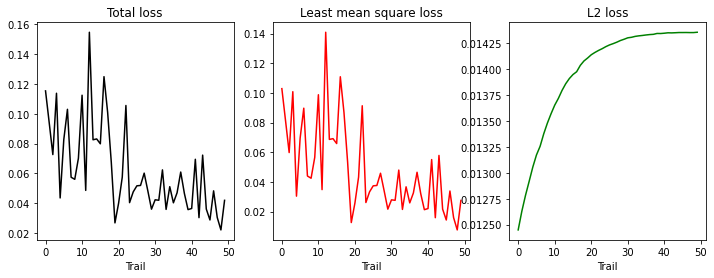

In [15]:
# Show the loss through training.
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(train_losses['total'], 'k')
plt.title('Total loss')
plt.xlabel('Trail')

plt.subplot(132)
plt.plot(train_losses['mse'], 'r')
plt.title('Least mean square loss')
plt.xlabel('Trail')

plt.subplot(133)
plt.plot(train_losses['l2'], 'g')
plt.title('L2 loss')
plt.xlabel('Trail')
plt.show()

[1.0203738 1.0203738]


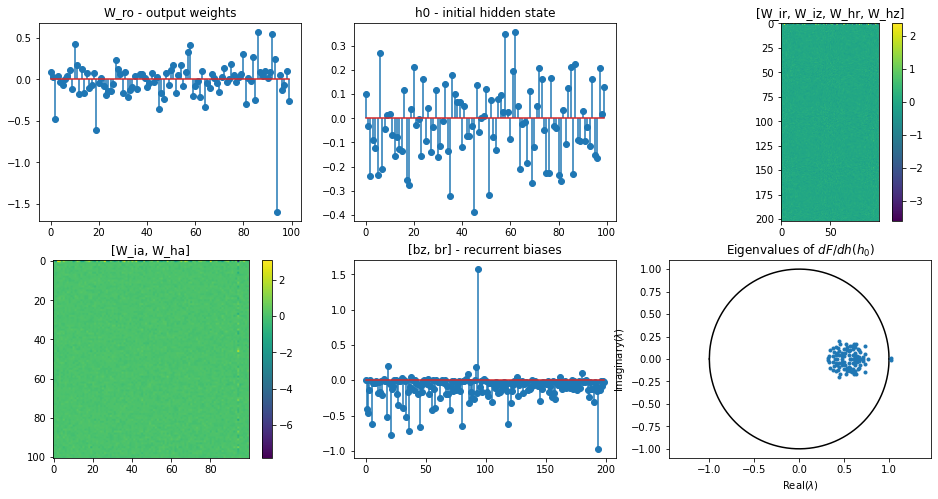

In [16]:
# show the trained weights
plot_params(net, show_top_eig=2)

## Testing

In [17]:
# net.load_states('./data/fixed_points.h5')

In [18]:
inputs, targets = build_inputs_and_targets(bval, sval, num_batch=num_batch, num_step=num_step, dt=dt)
hiddens, outputs = net.predict(inputs)

# plot_data(num_step, inputs=inputs, targets=targets, outputs=outputs, errors=np.abs(targets - outputs), num_plot=16)

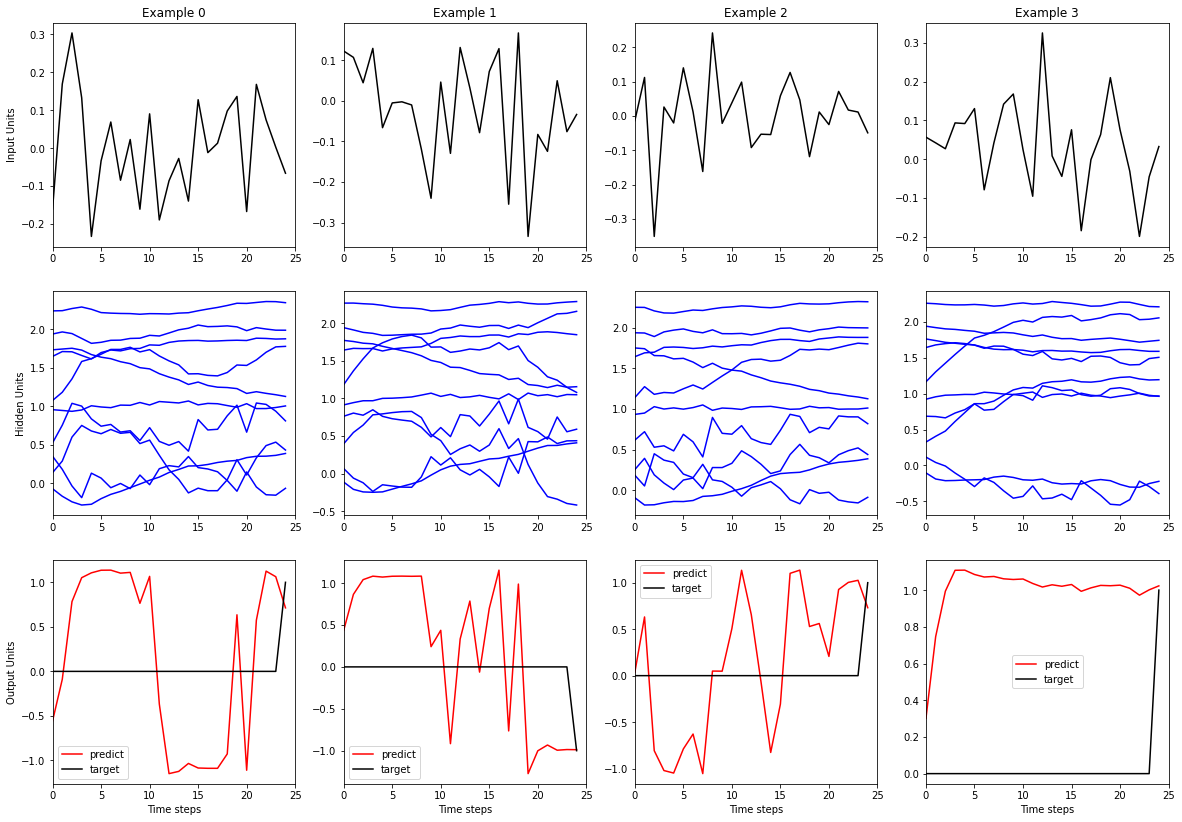

In [19]:
plot_examples(num_step, inputs=inputs, targets=targets, outputs=outputs, hiddens=hiddens, num_example=4)

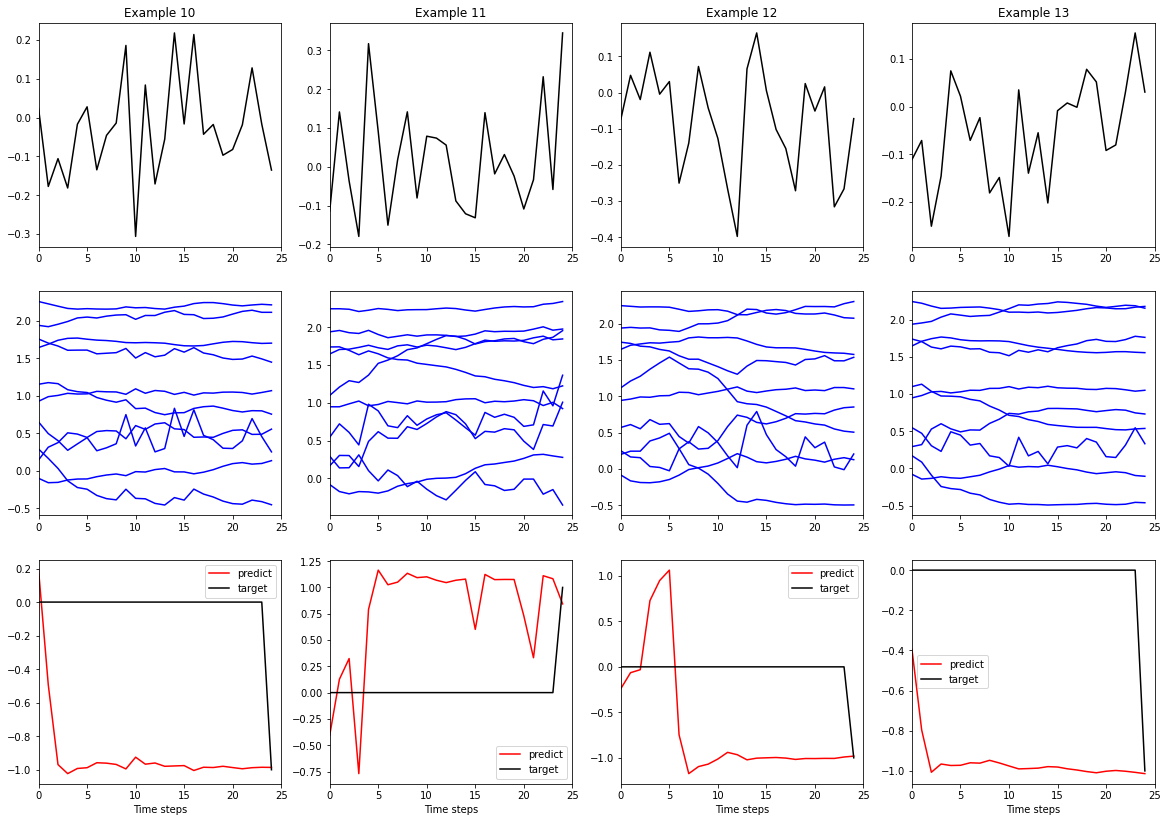

In [20]:
plot_examples(num_step, inputs=inputs, targets=targets, outputs=outputs, hiddens=hiddens, num_example=4, start_id=10)

## Fixed point analysis

Now that we've trained up this GRU to decide whether or not the perfect integral of the input is positive or negative, we can analyze the system via fixed point analysis.

The update rule of the GRU cell from the current state to the next state can be computed by：

In [21]:
f_cell = lambda h: net.cell(h, bm.zeros(net.num_input))

The function to determine the fixed point loss is given by the squared error of a point $(h - F(h))^2$:

Let's try to find the fixed points given the initial states.

In [22]:
fp_candidates = hiddens.reshape((-1, net.num_hidden))

In [91]:
finder = bp.analysis.numeric.FixedPointFinder(
  f_cell=f_cell,
  f_type='F',
  tol_outlier=.1,
  tol_opt=5e-7,
  tol_speed=1e-7,
  tol_unique=0.0005,
  opt_setting=dict(method=bm.optimizers.Adam,
                   lr=bm.optimizers.ExponentialDecay(0.2, 1, 0.9999),
                   eps=1e-8),
  num_opt_batch=400, 
)
fps, fp_losses, keep_ids, opt_losses = finder.find_fixed_points(candidates=fp_candidates)

Optimizing to find fixed points:
    Batches 1-400 in 2.40 sec, Training loss 0.0000009128
    Batches 401-800 in 2.38 sec, Training loss 0.0000016081
    Batches 801-1200 in 2.51 sec, Training loss 0.0000018042
    Batches 1201-1600 in 2.46 sec, Training loss 0.0000017379
    Batches 1601-2000 in 2.39 sec, Training loss 0.0000012492
    Batches 2001-2400 in 2.42 sec, Training loss 0.0000010462
    Batches 2401-2800 in 2.44 sec, Training loss 0.0000009211
    Batches 2801-3200 in 2.44 sec, Training loss 0.0000006409
    Batches 3201-3600 in 2.50 sec, Training loss 0.0000005178
    Batches 3601-4000 in 2.38 sec, Training loss 0.0000003693
    Stop optimization as mean training loss 0.0000003693 is below tolerance 0.0000005000.
Excluding fixed points with squared speed above tolerance 0.00000:
    Kept 2839/3750 fixed points with tolerance under 1e-07.
Excluding non-unique fixed points:
    Kept 845/2839 unique fixed points with uniqueness tolerance 0.0005.
Excluding outliers:
    Kept 8

### Verify fixed points

Plotting the quality of the fixed points.

In [93]:
%matplotlib inline

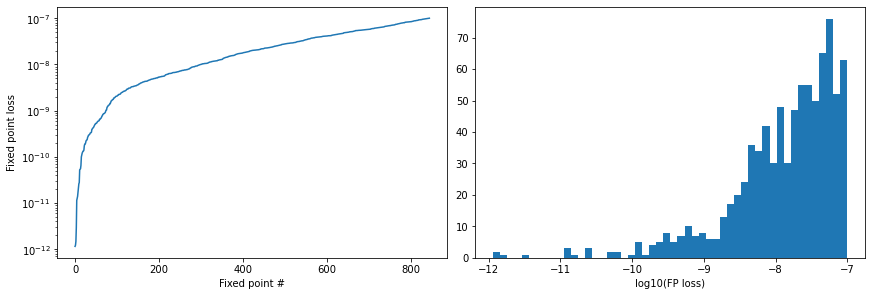

In [94]:
fig, gs = bp.visualize.get_figure(1, 2, 4, 6)

fig.add_subplot(gs[0, 0])
plt.semilogy(fp_losses)
plt.xlabel('Fixed point #')
plt.ylabel('Fixed point loss')

fig.add_subplot(gs[0, 1])
plt.hist(np.log10(finder.f_loss_batch(fps)), 50)
plt.xlabel('log10(FP loss)')
plt.show()

Let's run the system starting at these fixed points, without input, and make sure the system is at equilibrium there. Note one can have fixed points that are very unstable, but that does not show up in this example.

In [95]:
# num_example = len(fps)
# idxs = np.random.randint(0, len(fps), num_example)
# check_h = bm.Variable(fps[idxs])

num_example = len(fps)
idxs = np.random.randint(0, len(fps), num_example)
check_h = bm.Variable(fps)
check_o = bm.Variable(bm.zeros((num_example, net.num_output)))

f_check_update = bm.make_loop(net.make_update(check_h, check_o),
                              dyn_vars=list(net.vars().values()) + [check_h, check_o],
                              out_vars=[check_h, check_o])

_ins = bm.zeros((num_step, num_example, net.num_input))
_outs = bm.zeros((num_step, num_example, net.num_output))
slow_hiddens, slow_outputs = f_check_update(_ins)

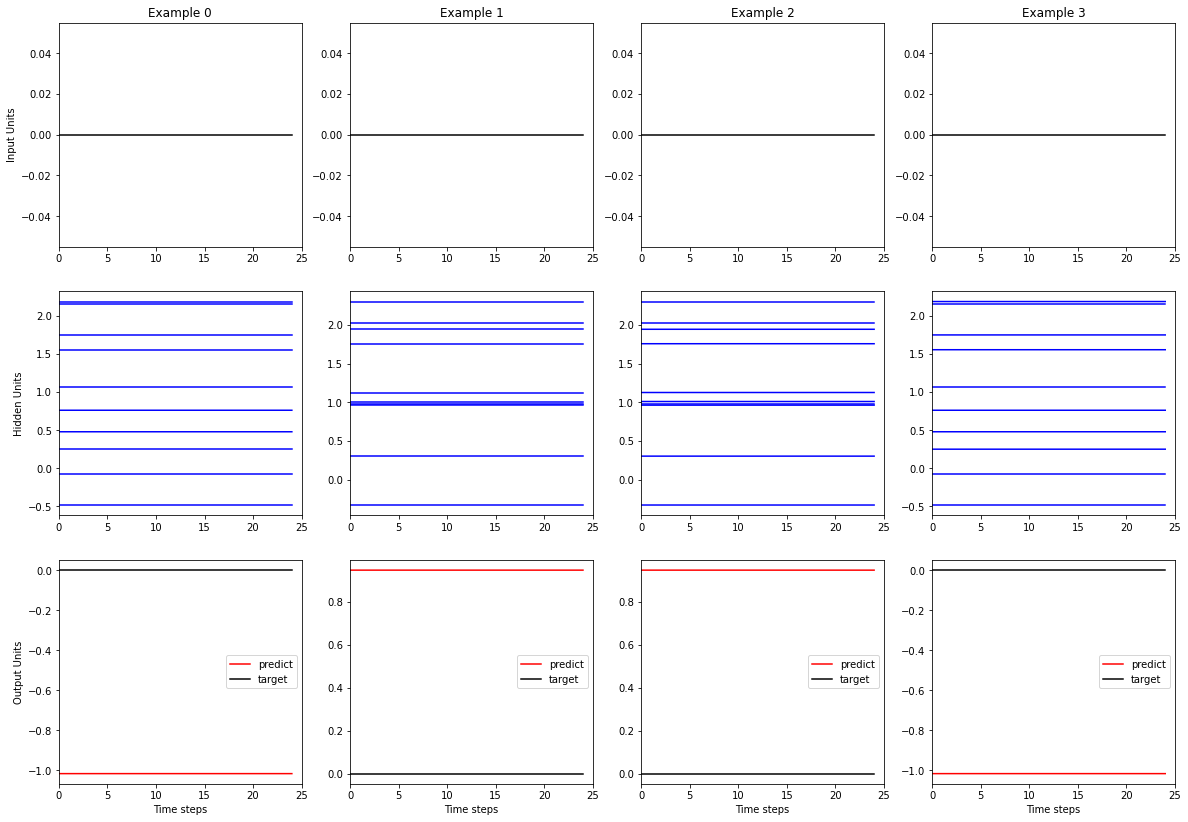

In [96]:
plot_examples(num_step, inputs=_ins, targets=_outs, outputs=slow_outputs, 
              hiddens=slow_hiddens, num_example=4)

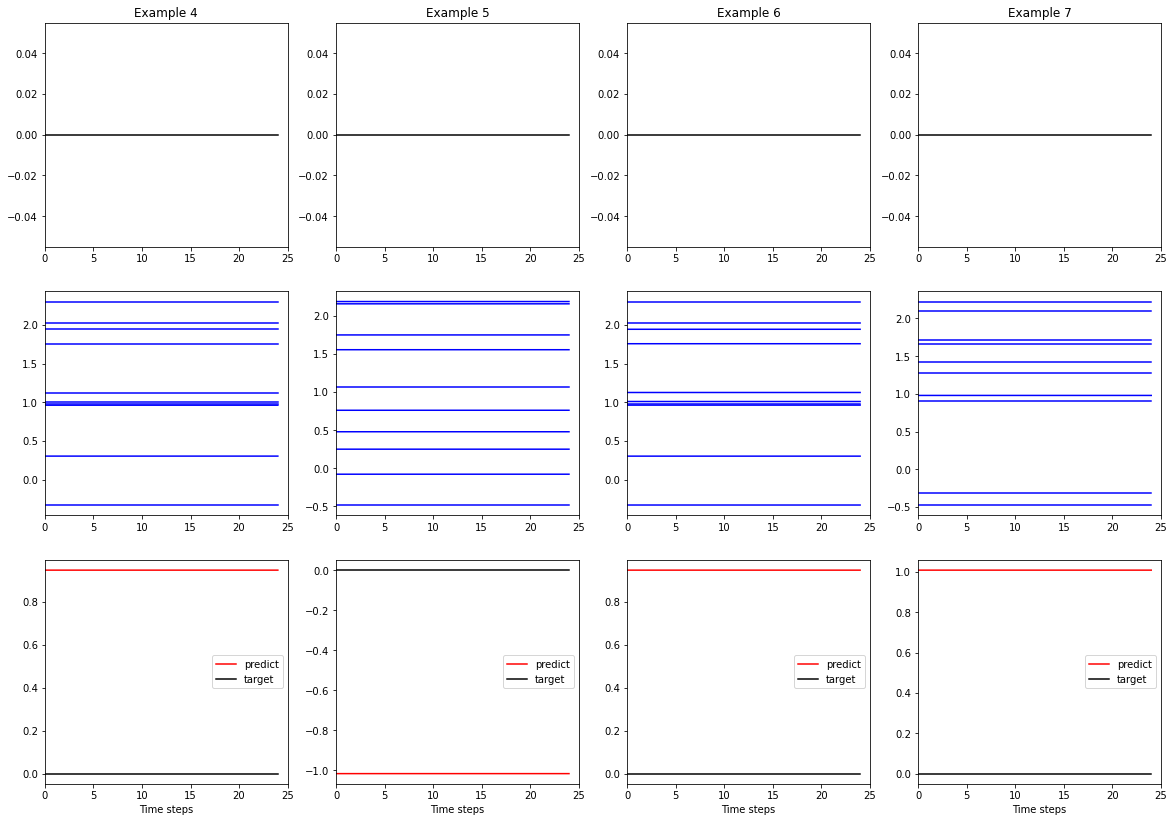

In [97]:
plot_examples(num_step, inputs=_ins, targets=_outs, outputs=slow_outputs, 
              hiddens=slow_hiddens, num_example=4, start_id=4)

Try to get a nice representation of the line using the fixed points.

In [98]:
# Sort the best fixed points by projection onto the readout.
fp_readouts = np.squeeze(net.readout(fps))
fp_ro_sidxs = np.argsort(fp_readouts)
sorted_fp_readouts = fp_readouts[fp_ro_sidxs]
sorted_fps = fps[fp_ro_sidxs]

downsample_fps = 1 # Use this if too many fps
sorted_fp_readouts = sorted_fp_readouts[0:-1:downsample_fps]
sorted_fps = sorted_fps[0:-1:downsample_fps]

### Visualize fixed points

Now, through a series of plots and dot products, we will see how the GRU solved the binary decision task. Now, let's  plot the fixed points and the fixed point candidates that the fixed point optimization was seeded with. Black shows the original candidate point, the colored stars show the fixed point, where the color of the fixed point is the projection onto the readout vector and the size is commensurate with how slow it is (slower is larger).

In [105]:
%matplotlib qt

In [106]:
from sklearn.decomposition import PCA

# fit candidates
pca = PCA(n_components=3).fit(fp_candidates)
# pca = PCA(n_components=3).fit(fps)

In [107]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

emax = fps.shape[0]

# # plot candidates
# h_pca = pca.transform(fp_candidates[keep_ids])
# emax = h_pca.shape[0] if h_pca.shape[0] < 1000 else 1000
# ax.scatter(h_pca[0:emax, 0], h_pca[0:emax, 1], h_pca[0:emax, 2], color=[0, 0, 0, 0.1], s=10)

# plot fixed points 
hstar_pca = pca.transform(fps)
color = np.squeeze(net.readout(fps))
color = np.where(color > 1.0, 1.0, color)
color = np.where(color < -1.0, -1.0, color)
color = (color + 1.0) / 2.0
marker_style = dict(marker='*', s=100, edgecolor='gray')
ax.scatter(hstar_pca[0:emax, 0], hstar_pca[0:emax, 1], hstar_pca[0:emax, 2], c=color[0:emax], **marker_style);

# alpha = 0.02
# for eidx in range(emax):
#     ax.plot3D([h_pca[eidx,0], hstar_pca[eidx,0]],
#               [h_pca[eidx,1], hstar_pca[eidx,1]],
#               [h_pca[eidx,2], hstar_pca[eidx,2]], 
#               c=[0, 0, 1, alpha])

plt.title('Fixed point structure and fixed point candidate starting points.')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()

So in this example, we see that the fixed point structure implements an approximate line attractor, which is the one-dimensional manifold likely used to integrate the white noise and ultimately lead to the decision.

Note also the shape of the manifold relative to the color.  The color is the based on the readout value of the fixed point, so it appears that there may be three parts to the line attractor.  The middle and two sides.  The two sides may be integrating, even though the the readout would be +1 or -1.

It's worth taking a look at the fixed points, and the trajectories started at the fixed points, without any input, all plotted in the 3D PCA space.

In [46]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')

alpha = 0.05
emax = len(sorted_fps)
for eidx in range(emax):
    h_pca = pca.transform(slow_hiddens[:, eidx, :])
    ax.plot3D(h_pca[:,0], h_pca[:,1], h_pca[:,2], c=[0, 0, 1, alpha])
        
size = 100
hstar_pca = pca.transform(sorted_fps)
color = np.squeeze(net.readout(sorted_fps))
color = np.where(color > 1.0, 1.0, color)
color = np.where(color < -1.0, -1.0, color)
color = (color + 1.0) / 2.0    
marker_style = dict(marker='*', s=size, edgecolor='gray')

ax.scatter(hstar_pca[0:emax, 0], hstar_pca[0:emax, 1], hstar_pca[0:emax, 2], 
           c=color[0:emax], **marker_style)

plt.title('High quality fixed points and the network dynamics initialized from them.')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()